In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes,brooklyn_zips,zip_list

from shapely import wkt

from IPython.display import display, Latex,Markdown
from tabulate import tabulate

In [4]:

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d39 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_39.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
finance = pd.read_csv('../../council_campaign_finance/data/located_data_subset_for_member_chapters.csv')
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)
nyc_zip = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA).geojson')
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
full_results_thirty_nine = full_results[full_results['district'] == 39]
full_results_thirty_nine['dpp20bs'] = full_results_thirty_nine['dpp20bs'] / 10
sh_full = full_results[full_results['candidate'] ==  'Shahana K. Hanif']
bw_full = full_results[full_results['candidate'] ==  'Brandon West']
#sh_full = sh_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]
bw_full = bw_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]

d39 = make_edname(d39)
d39_eds = d39['ed_name'].unique().tolist()


max_vote_share_candidates = pd.read_csv('../data/max_vote_share_candidates.csv')
tj = max_vote_share_candidates[['ed_name','candidate']]

occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip','w2cop']
wp_cols = [col for col in wp_cols if col not in to_remove]

C:\Users\samtg\AppData\Local\Temp\ipykernel_40140\2497930016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_results_thirty_nine['dpp20bs'] = full_results_thirty_nine['dpp20bs'] / 10


In [5]:
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')

In [6]:
demo_occ = sh_full[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p','white_transplant_ratio']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [7]:
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')

In [3]:
full_results_thirty_nine.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Shahana K. Hanif        11461.0
Brandon West             7978.0
Justin M. Krebs          5669.0
Douglas M. Schneider     4882.0
Briget Rein              2506.0
Jessica Simmons          1552.0
Mamnun M. Haq            1431.0
219478.0                  126.0
218085.0                  109.0
219449.0                  100.0
Write-in                   87.0
219463.0                   65.0
overvote                   59.0
221161.0                   27.0
219422.0                   25.0
218128.0                   23.0
Name: vote, dtype: float64

In [4]:
top_three = full_results_thirty_nine[full_results_thirty_nine['candidate'].isin(['Shahana K. Hanif','Brandon West','Justin M. Krebs'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [5]:
winners['candidate'].value_counts()

candidate
Shahana K. Hanif    100
Brandon West         27
Justin M. Krebs       6
Name: count, dtype: int64

In [6]:
def assign_color(row):
    if row['candidate'] == 'Shahana K. Hanif':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] == 'Brandon West':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])

In [7]:
winners['color'] = winners.apply(assign_color, axis=1)

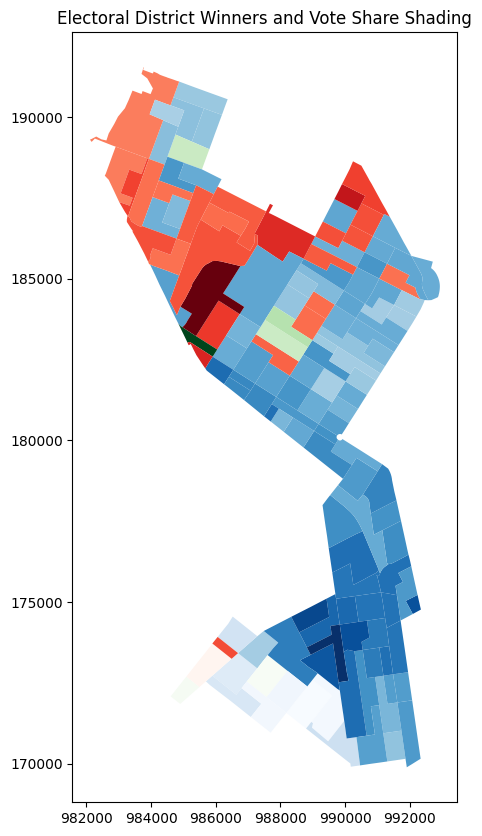

In [9]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))
fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [10]:
d39.groupby('district_39_choice_1')['district_39_choice_2'].value_counts(dropna=False).reset_index(name='count').sort_values('count', ascending=False).head(10)

,district_39_choice_1,district_39_choice_2,count
59,Shahana K. Hanif,Brandon West,5003
0,Brandon West,Shahana K. Hanif,3762
60,Shahana K. Hanif,Justin M. Krebs,1888
61,Shahana K. Hanif,NaN,1818
20,Douglas M. Schneider,Justin M. Krebs,1640
1,Brandon West,NaN,1412
2,Brandon West,Justin M. Krebs,1390
39,Justin M. Krebs,NaN,1380
21,Douglas M. Schneider,NaN,1262
40,Justin M. Krebs,Shahana K. Hanif,1104


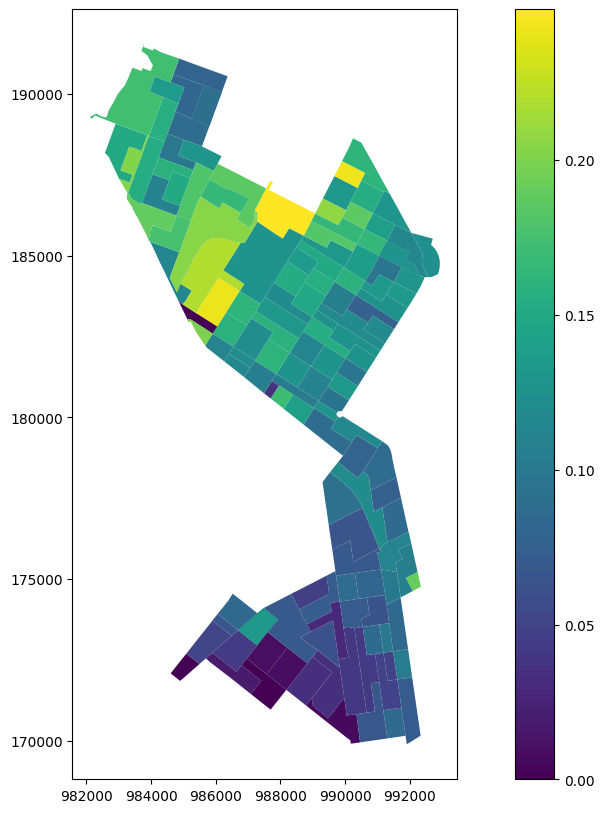

In [11]:
pc = make_precinct_counts(d39,'district_39','Shahana K. Hanif','Brandon West')
pc['total_votes'] = pc.iloc[:, 1:6].sum(axis=1)
pc = pc[['ed_name','Brandon West_notShahana K. Hanif','total_votes']]
pc.columns = ['ed_name','ch_notmh','total']
pc['ch_vote_share'] = pc['ch_notmh'] / pc['total']
el = full_results_thirty_nine[full_results_thirty_nine['winner'] == True]
map = pc.merge(el[['ed_name','geometry']],on='ed_name', how='left')
map = gpd.GeoDataFrame(map,geometry=map['geometry'].apply(wkt.loads))
map.plot(column='ch_vote_share', cmap='viridis', legend=True, figsize=(15, 10))
plt.show()

In [4]:
cor_cols = ['ed_name','vote_share','garcia213p','white_transplant_ratio','dpp20bs','nhb21p','nha21p','mhhi21','cvap21bapp','ind21p','bang21p'] + wp_cols
corr_df = sh_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_df = corr_df.merge(ae, left_on='ed_name', right_on='ElectDist', how='left')
corr_df['dpp20bs'] = corr_df['dpp20bs'] / 10
corr_matrix = corr_df[cor_cols].corr()
corr_matrix = corr_matrix.sort_values('vote_share')
vote_corr = corr_matrix[['vote_share']]

In [14]:
thirty_nine = ['Shahana Hanif','Brandon West']
thirty_nine_df = finance[finance['matched_name'].isin(thirty_nine)]
by_zip_39 = thirty_nine_df.groupby(['matched_name','ZIP'])['AMNT'].sum().reset_index()
by_zip_39['ZIP'] = by_zip_39['ZIP'].astype(str)
compare = by_zip_39.pivot(index='ZIP',columns='matched_name',values='AMNT').fillna(0).reset_index()
compare_nyc = compare[compare['ZIP'].isin(zip_list)]

C:\Users\samtg\AppData\Local\Temp\ipykernel_24312\4289472305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_nyc['dif'] = compare_nyc['Shahana Hanif'] - compare_nyc['Brandon West']


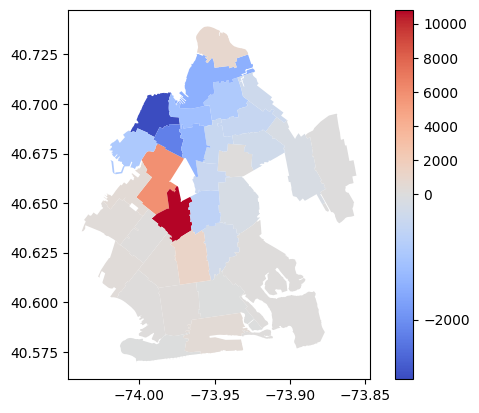

In [15]:
compare_nyc['dif'] = compare_nyc['Shahana Hanif'] - compare_nyc['Brandon West']
zip_map = compare_nyc.merge(nyc_zip, left_on='ZIP', right_on='zcta', how='left')
zip_map = gpd.GeoDataFrame(zip_map)

brooklyn_map = zip_map[zip_map['ZIP'].isin(brooklyn_zips)]
divnorm = colors.TwoSlopeNorm(vmin=brooklyn_map['dif'].min(), 
                              vcenter=0, 
                              vmax=brooklyn_map['dif'].max())
brooklyn_map.plot(column='dif', cmap='coolwarm', legend=True, norm=divnorm)
plt.show()

In [16]:
thirty_nine_df.groupby(['matched_name','ZIP'])['AMNT'].sum().reset_index().sort_values('AMNT',ascending=False).head(10)

,matched_name,ZIP,AMNT
413,Shahana Hanif,11215,15690.88
416,Shahana Hanif,11218,14495.00
116,Brandon West,11215,9778.08
118,Brandon West,11217,4652.55
105,Brandon West,11201,3948.00
119,Brandon West,11218,3679.82
134,Brandon West,11238,3383.67
117,Brandon West,11216,3290.02
129,Brandon West,11231,3106.71
414,Shahana Hanif,11216,2850.00


In [17]:
compare_nyc.sort_values('dif',ascending=True).head(10)

matched_name,ZIP,Brandon West,Shahana Hanif,dif
92,11201,3948.00,994.71,-2953.29
107,11217,4652.55,2436.00,-2216.55
102,11211,1919.11,451.88,-1467.23
126,11238,3383.67,2011.00,-1372.67
96,11205,1653.33,509.00,-1144.33
18,10024,1316.00,205.00,-1111.00
120,11231,3106.71,2176.00,-930.71
97,11206,976.36,80.00,-896.36
54,10463,972.00,173.00,-799.00
90,11106,1080.60,343.00,-737.60


In [18]:
thirty_nine_df.groupby('matched_name')['AMNT'].agg(['sum','mean','count'])

,sum,mean,count
matched_name,,,
Brandon West,75499.02,37.543023,2011
Shahana Hanif,86344.88,44.807929,1927


In [75]:
corr_df['log_mhhi21'] = np.log(corr_df['mhhi21'])
corr_df['doc_mhhi_interaction'] = corr_df['log_mhhi21'] * corr_df['w2docp']
corr_df['adm_mhhi_interaction'] = corr_df['log_mhhi21'] * corr_df['w2admp']
corr_df['coss_mhhi_interaction'] = corr_df['w2cossp'] * corr_df['log_mhhi21']
corr_df['cvap_mhhi_interaction'] = corr_df['cvap21bapp'] * corr_df['log_mhhi21']

In [84]:
target = corr_df['vote_share']
mod1 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p']])).fit()
mod3 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p','w2emrp','w2admp','w2cossp','w2docp']])).fit()
mod4 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p','w2emrp','w2admp','w2cossp','w2docp','garcia213p','dpp20bs']])).fit()
mod5 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p','w2emrp','w2admp','w2cossp','w2docp','garcia213p','dpp20bs','coss_mhhi_interaction']])).fit()

In [87]:
summary_col([mod1,mod2,mod3,mod4,mod5],stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII,vote_share IIIII
const,38.4650***,30.3334***,24.0085***,16.6698***,49.0551***
,(6.7906),(6.7154),(6.5098),(6.0229),(17.8270)
log_mhhi21,-1.1744*,-1.1636*,-0.6612,-0.2547,-3.4626**
,(0.6541),(0.6175),(0.5664),(0.5205),(1.7421)
cvap21bapp,0.0828*,0.1790***,0.0530,-0.5147***,-0.4882***
,(0.0463),(0.0497),(0.0556),(0.1150),(0.1145)
bang21p,,1.6617***,2.1901***,2.3812***,2.4175***
,,(0.4089),(0.3637),(0.3308),(0.3277)
w2emrp,,,1.1697***,1.0915***,1.0828***
,,,(0.2715),(0.2505),(0.2478)


In [22]:
corr_df['garacia_hanif_diff'] = (corr_df['garcia213p'] - corr_df['vote_share']).round(2)
corr_df['dpp_hanif_diff'] = (corr_df['dpp20bs'] - corr_df['vote_share']).round(2)

In [23]:
corr_df[['garcia213p','dpp20bs','vote_share','garacia_hanif_diff','dpp_hanif_diff']].describe()

,garcia213p,dpp20bs,vote_share,garacia_hanif_diff,dpp_hanif_diff
count,130.000000,130.000000,130.000000,130.000000,130.000000
mean,67.265127,16.600915,31.604841,35.660231,-15.003615
std,20.234659,7.455262,10.242703,20.371388,11.530305
min,7.366398,1.475033,4.137931,-18.640000,-48.920000
25%,67.021499,11.447357,25.332828,25.237500,-23.730000
50%,75.587704,16.300000,31.887755,43.035000,-13.160000
75%,79.748739,22.332588,37.756546,50.312500,-6.490000
max,83.592169,29.200001,59.345794,62.160000,4.750000


In [24]:
conditions = [
    (corr_df['garacia_hanif_diff'] > 0) & 
    (corr_df['dpp_hanif_diff'] > 0),
    
    (corr_df['garacia_hanif_diff'] < 0) & 
    (corr_df['dpp_hanif_diff'] < 0),

    (corr_df['garacia_hanif_diff'] > 0) & 
    (corr_df['dpp_hanif_diff'] < 0),

    (corr_df['garacia_hanif_diff'] < 0) & 
    (corr_df['dpp_hanif_diff'] > 0)
]

values = ['garcia_bernie', 'hanif_hanif', 'garcia_hanif', 'hanif_bernie'] 
corr_df["vote_diff"] = np.select(conditions, values, default=0)

In [25]:
corr_df['vote_diff'].value_counts()

vote_diff
garcia_hanif     111
garcia_bernie     10
hanif_hanif        9
Name: count, dtype: int64

In [51]:
corr_df['south_asian'] = (corr_df['bang21p'] + corr_df['ind21p'])
corr_df['income_binary'] = np.where(corr_df['mhhi21'] > 70000, 1, 0)

In [52]:
corr_map = corr_df.merge(ed_gdf, left_on='ed_name', right_on='ElectDist', how='left')
corr_map = gpd.GeoDataFrame(corr_map,geometry=corr_map['geometry'])

In [53]:
corr_map['vote_diff'] = corr_map['vote_diff'].astype('category')
corr_map['income_binary'] = corr_map['income_binary'].astype('category')

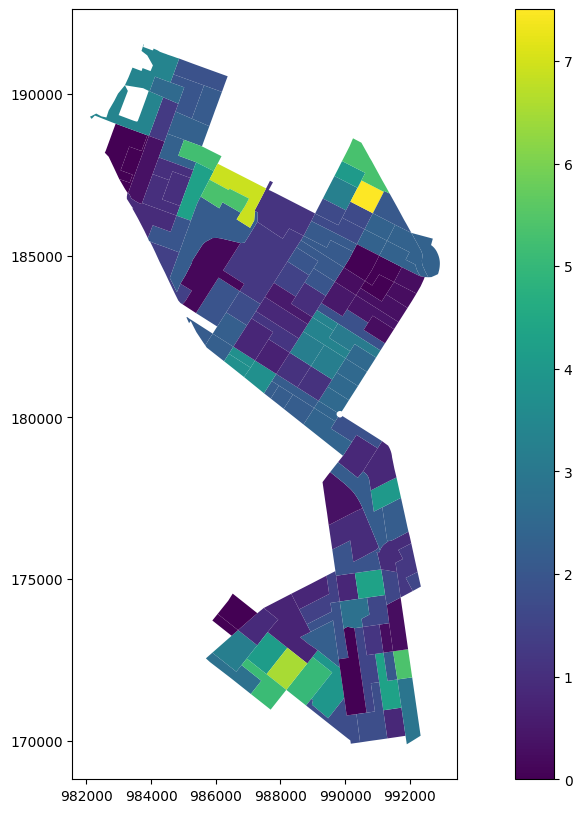

In [71]:
corr_map.plot(column='w2cossp', cmap='viridis', legend=True, figsize=(15, 10))
plt.show()

In [ ]:
target = corr_df['garacia_hanif_diff']
mod1 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p']])).fit()
mod3 = sm.OLS(target,sm.add_constant(corr_df[['log_mhhi21','cvap21bapp','bang21p','w2emrp','w2admp','w2cossp','w2docp']])).fit()
summary_col([mod1,mod2,mod3],stars=True)

In [30]:
summary_col([mod1,mod2,mod3],stars=True)

,garacia_hanif_diff I,garacia_hanif_diff II,garacia_hanif_diff III
const,-30.1301***,-18.8963***,-13.5542**
,(6.4587),(5.9044),(6.2566)
log_mhhi21,0.6568,0.6419,0.2668
,(0.6222),(0.5429),(0.5444)
cvap21bapp,0.8850***,0.7520***,0.8145***
,(0.0440),(0.0437),(0.0535)
bang21p,,-2.2957***,-2.5696***
,,(0.3595),(0.3495)
w2emrp,,,-0.8829***
,,,(0.2609)


In [97]:
# make sh_full['ad'] which is the first two digits of ed_name
sh_full['ed_name'] = sh_full['ed_name'].astype(str)
sh_full['ad'] = sh_full['ed_name'].str[:2]

In [99]:
sh_full['ad'].value_counts()

ad
52    60
44    58
51     9
48     2
42     1
Name: count, dtype: int64

In [101]:
jb = pd.read_csv('../data/max_vote_share_candidates.csv')

In [105]:
jb['ad'] = jb['precinct'].str[3:6]

In [109]:
jb.rename(columns={'vote_share':'jb_vote'}, inplace=True)

In [111]:
jb_corr = jb[['ed_name','jb_vote']].merge(corr_df, left_on='ed_name', right_on='ed_name', how='left')

In [117]:
# find out how many ed_names jb and corr_df have in common
jb_corr['ed_name'].nunique(), corr_df['ed_name'].nunique()
jb_corr = jb_corr[jb_corr['ed_name'].isin(corr_df['ed_name'].unique())]
jb_corr

,ed_name,jb_vote,vote_share,dpp20bs,garcia213p,white_transplant_ratio,mhhi21,cvap21bapp,h21p,nha21p,...,pak21p,sril21p,taiw21p,thai21p,viet21p,log_mhhi21,doc_mhhi_interaction,adm_mhhi_interaction,coss_mhhi_interaction,cvap_mhhi_interaction
22,51008,66.97,35.087719,22.584519,69.413985,24.282011,21602.135779,77.393520,15.132485,6.500183,...,0.055494,0.0,1.479841e-01,0.0,0.000000e+00,9.980547,11.183991,99.195236,14.212291,772.429700
23,51044,72.60,27.586207,14.724878,74.305045,21.912690,55945.601422,60.852518,35.955614,8.827914,...,0.000000,0.0,1.203132e-01,0.0,0.000000e+00,10.932135,27.821636,126.116714,21.243579,665.247946
25,51046,63.64,40.000000,16.199170,71.761343,18.194420,9038.536642,58.812203,40.797965,11.365625,...,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,9.109253,12.711009,86.858559,19.596138,535.735215
62,52057,62.83,33.840304,17.557127,72.883676,27.932197,77189.334769,79.873326,17.504861,9.029411,...,0.000000,0.0,2.732483e-01,0.0,2.530549e-01,11.254017,25.165071,123.719376,36.331983,898.895731
63,52058,70.75,29.870130,23.499999,71.698117,25.355692,34494.621767,74.501186,12.398376,8.612805,...,0.000000,0.0,7.876015e-01,0.0,1.778455e-01,10.448559,34.048258,117.040910,17.556132,778.430019
64,52059,63.53,31.632653,23.500001,71.698116,25.355692,50688.744374,74.501186,12.398374,8.612805,...,0.000000,0.0,7.876017e-01,0.0,1.778455e-01,10.833459,35.302516,121.352401,18.202860,807.105559
65,52060,65.93,29.304029,23.499998,71.698113,25.355691,35860.159718,74.501186,12.398375,8.612804,...,0.000000,0.0,7.876015e-01,0.0,1.778456e-01,10.487382,34.174771,117.475771,17.621374,781.322413
66,52061,63.53,29.483283,16.899998,72.436745,26.502001,105363.904561,84.543754,14.853136,6.809078,...,0.000000,0.0,0.000000e+00,0.0,5.674232e-01,11.565175,62.391818,177.533087,86.781348,977.763348
67,52062,63.82,24.229075,14.400000,73.513511,29.300961,60361.453134,82.727269,20.217664,9.250732,...,0.000000,0.0,1.100920e-14,0.0,2.930096e-01,11.008106,18.635246,119.798005,44.591480,910.670544
68,52089,67.93,37.021277,22.100000,82.653064,28.793520,73413.827419,82.881140,12.437049,7.970222,...,0.240858,0.0,3.722356e-01,0.0,0.000000e+00,11.203868,70.397494,86.183607,23.465831,928.589314


In [118]:
target = jb_corr['vote_share']
mod1 = sm.OLS(target,sm.add_constant(jb_corr[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target,sm.add_constant(jb_corr[['log_mhhi21','cvap21bapp','jb_vote']])).fit()
mod3 = sm.OLS(target,sm.add_constant(jb_corr[['log_mhhi21','cvap21bapp','jb_vote','bang21p']])).fit()
mod4 = sm.OLS(target,sm.add_constant(jb_corr[['log_mhhi21','cvap21bapp','jb_vote','bang21p','w2emrp','w2admp','w2cossp','w2docp']])).fit()
summary_col([mod1,mod2,mod3,mod4],stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII
const,39.3109,49.9798,-16.4816,18.2263
,(24.0990),(38.4191),(40.9380),(46.5934)
log_mhhi21,-1.5899,-1.0575,-3.6180,-2.8038
,(3.1731),(3.5767),(3.1680),(3.3898)
cvap21bapp,0.0787,0.0156,0.7799*,0.7278*
,(0.2797),(0.3360),(0.4038),(0.3728)
jb_vote,,-0.1739,0.3324,-0.2883
,,(0.4785),(0.4464),(0.4554)
bang21p,,,6.0172**,7.4570
,,,(2.2634),(4.8713)


EFA

In [17]:
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [14]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [19]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [15]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop'] + wp_cols

In [20]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.49117086 0.17488867 0.41633418 0.5146485  0.69309225 0.14531961
 0.25826295 0.26664078 0.41883007 0.22034424 0.15994414 0.6200484
 0.73967326 0.40936118 0.5515212  0.34863914 0.21033365 0.19148205
 0.21042691 0.68603318 0.3336203  0.25171878 0.58405206 0.33804028
 0.44846048 0.48941236 0.35041134 0.13706733 0.6813673  0.26152919
 0.6160736  0.54388782 0.30428581 0.69169108 0.13644658 0.09612611
 0.60174665 0.62335875 0.40208277 0.48086437 0.52229195 0.08619059
 0.74650959 0.29157619 0.29940728 0.83684585 0.52531126]
Overall KMO: 0.45112632536878733
Bartlett’s test χ²: 7295.484557888678 p-value: 0.0


In [21]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'w2farmp' (KMO=0.086); new overall KMO before recalculation = 0.451
Dropping 'w2ffp' (KMO=0.157); new overall KMO before recalculation = 0.512
Dropping 'nhb21p' (KMO=0.148); new overall KMO before recalculation = 0.516
Dropping 'w2cossp' (KMO=0.158); new overall KMO before recalculation = 0.564
Dropping 'greek21p' (KMO=0.229); new overall KMO before recalculation = 0.589
Dropping 'venez21p' (KMO=0.243); new overall KMO before recalculation = 0.608
Dropping 'domin21p' (KMO=0.253); new overall KMO before recalculation = 0.639
Dropping 'hh21bop' (KMO=0.277); new overall KMO before recalculation = 0.659
Dropping 'filip21p' (KMO=0.291); new overall KMO before recalculation = 0.662
Dropping 'w2emrp' (KMO=0.316); new overall KMO before recalculation = 0.683
Dropping 'arab21p' (KMO=0.309); new overall KMO before recalculation = 0.697
Dropping 'colomb21p' (KMO=0.329); new overall KMO before recalculation = 0.709
Dropping 'w2copp' (KMO=0.327); new overall KMO before recalculation = 0.71

In [22]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

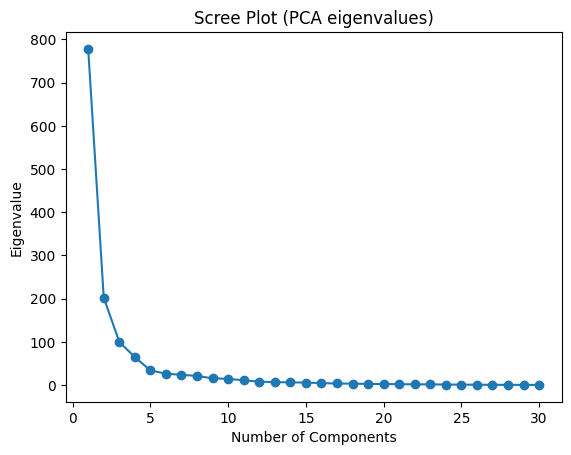

In [23]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [24]:
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [25]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [26]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1   Factor2   Factor3   Factor4   Factor5
nhw21p                  -6.963260 -5.387202 -9.507904  1.850468  0.725103
h21p                     2.595967  0.327858  5.843754  2.079835  0.273266
nha21p                   5.584854  3.627340  3.067740 -3.280722  0.705826
cvap21bapp             -19.269974  4.900350  0.326000  0.168690  0.095458
kor21p                  -0.370277  0.201388  0.152034 -0.151026 -0.017558
mex21p                   2.175240  0.162150  2.900523  2.953875  0.264801
white_transplant_ratio  -8.775123  0.489302 -0.270318  1.139878  1.435355
ind21p                   1.760111  1.651837 -0.575305 -0.693215 -1.041762
bang21p                  1.583574  1.496400 -0.110214  0.385755  0.035230
pak21p                   1.114473  0.850468  0.406990 -1.009253  0.964897
fb21bdp                  2.616764  2.049496 -0.493638  0.123823  0.039069
fb21drp                  0.200085  0.013319  0.601182  0.683912 -0.026203
w2mgtp              

In [34]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(demo_occ[['bang21p','ind21p','white_transplant_ratio','log_mhhi21','w2admp','cvap21bapp','w2lawp']])).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     9.423
Date:                Wed, 04 Jun 2025   Prob (F-statistic):           2.61e-09
Time:                        15:48:38   Log-Likelihood:                -458.32
No. Observations:                 130   AIC:                             932.6
Df Residuals:                     122   BIC:                             955.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     15